In [1]:
from photoObject import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.optimize import minimize
import math
import scipy.special as scispe
from random import Random
import random
from scipy.interpolate import interp1d
import copy
import Tools
from astropy.table import Table
import xmatch


In [2]:
cat=ReadCatalogs("../../../A-Catalogs/Binospec-Candels.cat")

cat["EWLya"]

<Column name='EWLya' dtype='float64' length=236>
 72.48630758545622
 200.6830731746896
 648.7903514138017
1.1938341884595083
 2.960784038607375
16.646361641993007
 30.22407025442198
13.131579415413936
 33.98810144914495
               nan
 7.600766993389711
11.884986470472684
               ...
2.7577468259395275
 2.247018073109192
 1.572839436225177
 2.996335494656833
 4637.294048490293
 1.240768171117458
 7.162429584473384
3751.4597326040785
 3118.769647851896
  7.53596059392746
 4.839771114829749
1.3730801604657903

## Load Data 3DHST

In [3]:
%load_ext autoreload
%autoreload 
%reload_ext autoreload


cat=ReadCatalogs("../../../A-Catalogs/Binospec-Candels.cat")
cat=cat[cat["EWLya"]>0]

Gabe=ascii.read("../../../A-Catalogs/goodsn_3dhst.v4.1.cat")

idx,d2d=xmatch.xmatch(cat["ra_candels"],cat["dec_candels"],Gabe["ra"],Gabe["dec"])
mask=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask.append(True)
    else:
        mask.append(False)

newCat=[Table(Gabe[i]) for i in idx]

for i in range(0,len(newCat)):
    newCat[i]["z"]=cat[i]["z"]
    newCat[i]["photoz"]=cat[i]["photoz"]
    newCat[i]["zsys"]=cat[i]["zsys"]
    newCat[i]["LyaFlux"]=cat[i]["LyaFlux"]
    newCat[i]["LyaErr"]=cat[i]["LyaErr"]
    newCat[i]["FluxLim"]=cat[i]["FluxLim"]
Photometry = [PhotoObject(c) for c in newCat ]
#filterNames     =   ['KPNO_U_FLUX', 'LBC_U_FLUX', 'ACS_F435W_FLUX', 'ACS_F606W_FLUX', 'ACS_F775W_FLUX', 'ACS_F814W_FLUX', 'ACS_F850LP_FLUX', 'WFC3_F105W_FLUX', 'WFC3_F125W_FLUX', 'WFC3_F140W_FLUX', 'WFC3_F160W_FLUX']
#filtErrNames    =   [ 'KPNO_U_FLUXERR', 'LBC_U_FLUXERR', 'ACS_F435W_FLUXERR', 'ACS_F606W_FLUXERR', 'ACS_F775W_FLUXERR', 'ACS_F814W_FLUXERR', 'ACS_F850LP_FLUXERR', 'WFC3_F105W_FLUXERR', 'WFC3_F125W_FLUXERR', 'WFC3_F140W_FLUXERR', 'WFC3_F160W_FLUXERR']
#centralWavelengths  = [3584.07,3579.29,4356.59,6000.37,7702.41,8196.29,9193.55,10651.00,12576.18,14061.91,15436.30]
#EffectiveWidth      = [592.73,479.17,776.58,1871.31,1299.92,1933.96,1549.7,2371.97,2674.40,3569.86,2750.15]


Cwaves  = [ 8984, 11433.62,	14872.56,19680.41,27278.58,	33537.23,35287.04,40723.18,43504.26	]
Cwaves=Cwaves+[ 	4360.06  , 6035.73 , 7730.77 ,8129.21,9080.26 ,  12503.91 , 13983.36 , 15437.71 ]
EffW    = [ [8098.0,9870], [10406.1,12461.1] ,[13427.345,16317.775],[17585.215,21775.605], [23971.275,30585.885],[31842.52,35231.94],[31667.39,38906.69],[38591.75,42854.61],[38166.26,48842.26]]# , 1098    , 3856     , 1232  ]
EffW=EffW+[ [3610.23,4883.77	],[	4634.30,7180.10]    , [6803.72,8631.82]   , [6869.59,9632.01	]  ,[8007.01,10862.13] ,  [10853.22, 14141.73] , [11864.94,16133.14] , [13857.70,17003.09] ]
Filters=np.array(["f090w_flux_aper_1","f115w_flux_aper_1","f150w_flux_aper_1","f200w_flux_aper_1","f277w_flux_aper_1","f335m_flux_aper_1","f356w_flux_aper_1","f410m_flux_aper_1","f444w_flux_aper_1"])
FiltNamesJWST   =  [name.replace("flux","mag") for name in Filters]
FiltErrNamesJWST=  [name.replace("flux","magerr") for name in Filters]


for i in range(0,len(newCat)):
    for name in FiltNamesJWST:
        newCat[i][name] = cat[i][name]

for i in range(0,len(newCat)):
    for name in FiltErrNamesJWST:
        newCat[i][name] = cat[i][name]

flts=["_F435W","_F606W","_F775W","_I","_F850LP","_F125W","_F140W","_F160W"]#,"555","110","625"] 
flt=["f"]
flterr=["e"]
FiltNames   =  []
FiltErrNames=  []
for i in flts:
    FiltNames.append(flt[0]+i)
    FiltErrNames.append(flterr[0]+i)

for i in FiltNamesJWST:
    FiltNames.append(i)
for i in FiltErrNamesJWST:
    FiltErrNames.append(i)

UselessVariable = [gal.setFilters(FiltNames,FiltErrNames) for gal in Photometry]
UselessVariable = [gal.setCWave(Cwaves) for gal in Photometry]
UselessVariable = [gal.setEffWidth(EffW) for gal in Photometry]

for gal in Photometry[:]:
    for f in FiltNames[:8]:
        if gal.cat[f]<40.0:
            flux=copy.deepcopy(gal.cat[f])
            gal.cat[f]=Tools.Flux2MagAB_Gabe(gal.cat[f])
            magP=Tools.Flux2MagAB_Gabe((flux+gal.cat["e"+f[1:]]))
            magM=Tools.Flux2MagAB_Gabe((flux-gal.cat["e"+f[1:]]))
            gal.cat["e"+f[1:]]=np.mean([magM-gal.cat[f],gal.cat[f]-magP])

"""
slopes  =  np.array([p.giveCat()["slope"] for p in Photometry]) #np.array([p.calculateUVslope(ShowPlots=False) for p in Photometry])
Muv     =   np.array([p.giveCat()["Muv"] for p in Photometry])#np.array([p.calculateMUV() for p in Photometry])
dMuv  =  np.array([p.giveCat()["dMuv"] for p in Photometry]) #np.array([p.MuvErr for p in Photometry])
zs  =   np.array([p.redshift for p in Photometry])
FWHM    =   np.array([p.giveCat()["LyaFWHM"] for p in Photometry])
LyaLum  =   np.array([p.calculateLumLya() for p in Photometry])
Skewness    =   np.array([p.giveCat()["Skewness"] for p in Photometry])
EW      = np.array([p.giveCat()["EWLya"] for p in Photometry])  #np.array([p.calculateEW() for p in Photometry])
dEW=np.array([p.giveCat()["dEWLya"] for p in Photometry])#np.array([p.getEWError() for p in Photometry])
dSlp=np.array([p.giveCat()["dslope"] for p in Photometry])#np.array([p.UVfitErrs[0] for p in Photometry])
dMuv=np.array([p.giveCat()["dMuv"] for p in Photometry])#np.array([p.MuvErr for p in Photometry])
"""



/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/D-EWModel/EWLya model/Old/Tools.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(f)+25
/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/D-EWModel/EWLya model/Old/Tools.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(f)+25


'\nslopes  =  np.array([p.giveCat()["slope"] for p in Photometry]) #np.array([p.calculateUVslope(ShowPlots=False) for p in Photometry])\nMuv     =   np.array([p.giveCat()["Muv"] for p in Photometry])#np.array([p.calculateMUV() for p in Photometry])\ndMuv  =  np.array([p.giveCat()["dMuv"] for p in Photometry]) #np.array([p.MuvErr for p in Photometry])\nzs  =   np.array([p.redshift for p in Photometry])\nFWHM    =   np.array([p.giveCat()["LyaFWHM"] for p in Photometry])\nLyaLum  =   np.array([p.calculateLumLya() for p in Photometry])\nSkewness    =   np.array([p.giveCat()["Skewness"] for p in Photometry])\nEW      = np.array([p.giveCat()["EWLya"] for p in Photometry])  #np.array([p.calculateEW() for p in Photometry])\ndEW=np.array([p.giveCat()["dEWLya"] for p in Photometry])#np.array([p.getEWError() for p in Photometry])\ndSlp=np.array([p.giveCat()["dslope"] for p in Photometry])#np.array([p.UVfitErrs[0] for p in Photometry])\ndMuv=np.array([p.giveCat()["dMuv"] for p in Photometry])#np.a

In [4]:
# Assuming 'Jades Data' is indicated by the presence of specific filter names in the object's catalog
jades_filters = set(FiltNamesJWST)
jades_filters_errs = set(FiltErrNamesJWST)
for obj in Photometry:
    c=obj.cat
    filternames=obj.filterNames

    if sum(np.isnan(c[filter_name]) == False for filter_name in jades_filters) < 2:
        obj.filterNames = np.array([name for name in obj.filterNames if name not in jades_filters])
        obj.filterNames = np.array([name for name in obj.filterNames if name not in jades_filters_errs])
        delete_Cwaves=[ 8984, 11433.62,	14872.56,19680.41,27278.58,	33537.23,35287.04,40723.18,43504.26	]
        obj.centralWavelengths = np.array([wave for wave in obj.centralWavelengths if wave not in delete_Cwaves])
        delete_EffW=[ [8098.0,9870], [10406.1,12461.1] ,[13427.345,16317.775],[17585.215,21775.605], [23971.275,30585.885],[31842.52,35231.94],[31667.39,38906.69],[38591.75,42854.61],[38166.26,48842.26]]
        # Convert lists to sets for efficient lookup and deletion
        x_set = {tuple(item) for item in obj.FilterEffWidth}
        y_set = {tuple(item) for item in delete_EffW}

        # Find elements of y in x and delete them
        x_set.difference_update(y_set)

        # Convert the set back to a list of lists
        obj.FilterEffWidth = np.array([list(item) for item in x_set])

        

    elif sum(np.isnan(c[filter_name]) == False for filter_name in jades_filters) >= 2:
        obj.filterNames = np.array([name for name in obj.filterNames if name in jades_filters or name in jades_filters_errs])
        delete_Cwaves=[ 4360.06  , 6035.73 , 7730.77 ,8129.21,9080.26 ,  12503.91 , 13983.36 , 15437.71 ]
        obj.centralWavelengths = np.array([wave for wave in obj.centralWavelengths if wave not in delete_Cwaves])
        delete_EffW=[ [3610.23,4883.77	],[	4634.30,7180.10]    , [6803.72,8631.82]   , [6869.59,9632.01	]  ,[8007.01,10862.13] ,  [10853.22, 14141.73] , [11864.94,16133.14] , [13857.70,17003.09] ]
        # Convert lists to sets for efficient lookup and deletion       
        x_set = {tuple(item) for item in obj.FilterEffWidth}
        y_set = {tuple(item) for item in delete_EffW}

        # Find elements of y in x and delete them
        x_set.difference_update(y_set)

        # Convert the set back to a list of lists
        obj.FilterEffWidth = np.array([list(item) for item in x_set])
  


In [5]:
a=[True,False,True]
print(sum(a))

2


In [6]:
%load_ext autoreload
%autoreload 
%reload_ext autoreload
slope=np.array([p.calculateUVslope(ShowPlots=False) for p in Photometry[:]])
muv=np.array([p.calculateMUV() for p in Photometry])
EWLya=np.array([p.calculateEW() for p in Photometry])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/D-EWModel/EWLya model/Old/Tools.py:289: RuntimeWarning: invalid value encountered in log10
  logFerr=np.median([np.log10(fluxes-fluxesErr)-np.log10(fluxes),np.log10(fluxes)-np.log10(fluxes+fluxesErr)],axis=0)
/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [7]:
Photometry[3].centralWavelengths

array([ 8984.  , 11433.62, 14872.56, 19680.41, 27278.58, 33537.23,
       35287.04, 40723.18, 43504.26])

101.31047075871889 72.48630758545622
176.4752806762651 200.6830731746896
192.83566937029514 648.7903514138017
18.53633881793055 1.1938341884595083
145.80064006030986 2.960784038607375
151.19914423408557 16.646361641993007
180.1457179758016 30.22407025442198
105.14475646981475 13.131579415413936
111.5458385282554 33.98810144914495
92.22322022279106 7.600766993389711
127.66257573003152 11.884986470472684
137.95968389526456 779.2956169311999
57.45747789336816 3.7542127724173806
773.1510458404592 5432.698628076205
221.67794637514885 186.9727154111759
196.05037892072247 574.8031780902845
81.30951597875801 3.8541844848597773
139.1972382882639 60.2162478323222
187.29425981078614 7288.581354257568
20.5740600578487 2.3798490426086327
449.07294708943914 3262.938343260615
28.057819864873647 2.478856040175485
9.852666250082942 1.423818044996397
347.72164445951074 1068.7575666147784
33.3018302196836 3.3161736503102643
40.5276478411871 4.574597699595972
40.03914642023824 46.210494019194286
109.04950

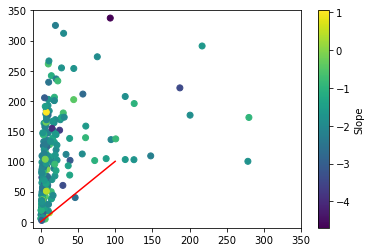

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   3., 226.]),
 array([-236468.55538344, -231732.90997028, -226997.26455711,
        -222261.61914395, -217525.97373078, -212790.32831762,
        -208054.68290445, -203319.03749129, -198583.39207812,
        -193847.74666495, -189112.10125179, -184376.45583862,
        -179640.81042546, -174905.16501229, -170169.51959913,
        -165433.87418596, -160698.22877279, -155962.58335963,
        -151226.93794646, -146491.2925333 , -141755.64712013,
        -137020.00170697, -132284.3562938 , -127548.71088064,
        -122813.06546747, -118077.4200543 , -113341.77464114,
        -108606.12922797, -103870.48381481,  -99134.83840164,
         -94399.19298848,  -89663.5475

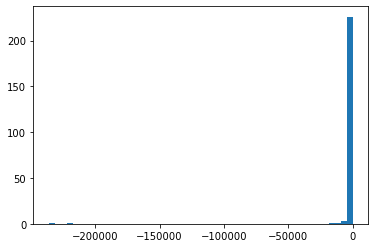

In [8]:
new,old=[],[]
for i in range(0,len(Photometry)):
    print(Photometry[i].EW,cat[i]["EWLya"])
    new.append(Photometry[i].EW)
    old.append(cat[i]["EWLya"])

#plt.scatter(new,old)
slopes = cat["slope"]
sc = plt.scatter(old,new, c=slopes, cmap='viridis')
plt.plot([0,100],[0,100],color="red")
plt.colorbar(sc, label='Slope')
plt.xlim(-10,350)
plt.ylim(-10,350)
plt.show()


plt.hist(np.array(new)-np.array(old),bins=50)

In [9]:
for i in range(0,len(cat)):
    print(cat[i]["id_charlotte"])
    print(muv[i])

z6_GNW_30051
-19.991244874142964
z5_GNW_10084
-19.58556799887429
z5_GNW_15423
-19.712982454458988
z6_GND_16819
-21.16139785202264
z5_GND_30190
-19.00906044281316
z5_GND_15562
-19.35919075718443
z5_GND_44499
-19.24455214686904
z6_GNW_27915
-19.673171097405664
z6_GNW_25538
-19.721906304444254
z6_GNW_23437
-20.351332592954883
z5_GNW_22336
-19.849900117825932
z6_GNW_22717
-20.18011725058333
z6_GNW_23350
-20.353796034358503
z6_GNW_20152
-18.418354944271357
z6_GNW_32543
-19.439786613306772
z6_GNW_4311
-20.288928368112458
z6_GNW_6440
-20.175745129461568
z6_GNW_8472
-19.505406959824526
z6_GNW_22555
-19.993794438481345
z6_GNW_1169
-21.458777329671115
z6_GNW_2045
-18.94092561369569
z6_GNW_2993
-20.31145904937741
z6_GNW_6554
-22.488093604998703
z6_GNW_7317
-19.31075655634573
z5_GNW_12024
-19.758310667194586
z6_GNW_10421
-21.001360209359433
z6_GNW_10970
-21.061619484856273
z5_GNW_11324
-19.904708331219943
z6_GNW_14511
-20.019808965594194
z6_GNW_16141
-19.465785726465697
z6_GNW_10822
-19.6010936283

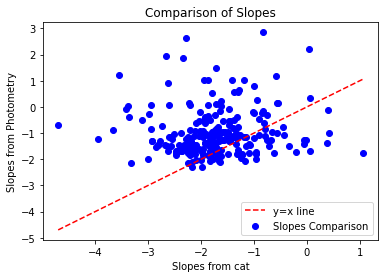

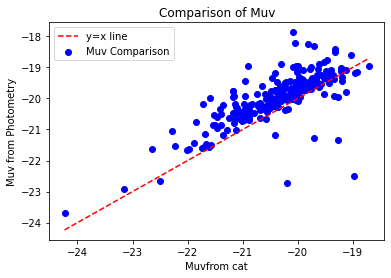

In [10]:
# Extract slopes from Photometry objects
photometry_slopes = slope

# Extract slopes from cat table
cat_slopes = cat["slope"]

# Create a scatter plot to compare the slopes
plt.scatter(cat_slopes, photometry_slopes, c='blue', label='Slopes Comparison')
plt.plot([min(cat_slopes), max(cat_slopes)], [min(cat_slopes), max(cat_slopes)], color='red', linestyle='--', label='y=x line')
plt.xlabel('Slopes from cat')
plt.ylabel('Slopes from Photometry')
plt.legend()
plt.title('Comparison of Slopes')
plt.show()


# Extract slopes from Photometry objects
photometry_slopes = muv

# Extract slopes from cat table
cat_slopes = cat["Muv"]

# Create a scatter plot to compare the slopes
plt.scatter(cat_slopes, photometry_slopes, c='blue', label='Muv Comparison')
plt.plot([min(cat_slopes), max(cat_slopes)], [min(cat_slopes), max(cat_slopes)], color='red', linestyle='--', label='y=x line')
plt.xlabel('Muvfrom cat')
plt.ylabel('Muv from Photometry')
plt.legend()
plt.title('Comparison of Muv')
plt.show()

(0.0, 400.0)

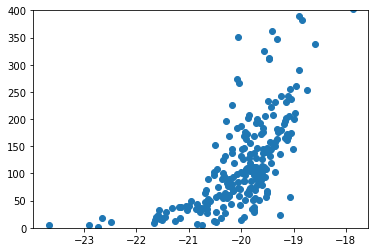

In [13]:
plt.scatter(muv,EWLya)
plt.ylim(0,400)

In [14]:
cat["EWLya"]=EWLya
ascii.write(cat,"../../../A-Catalogs/Binospec-Candels.cat",format="csv",overwrite=True)

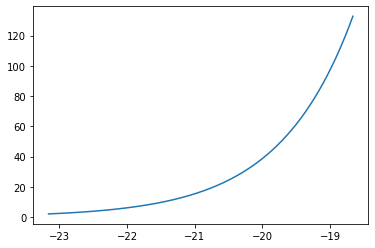

In [69]:
plt.plot(muvs,ewlim)

In [32]:
np.log10(1.46e-17)

-16.835647144215564

In [4]:
def duplicate(data):
    return np.concatenate((data,data))

mask=[]
# Objects with all the individual data
for s,m,e in zip(slopes,Muv,EW):
    if -22<m<-18 and np.isnan(e)==False:
    #if m<-18 and np.isnan(e)==False:
        mask.append(True)
    else:
        mask.append(False)


BGal = np.array([BayesGalaxy(c) for c in cat ])
for i in range(0,len(BGal)):
    BGal[i].Lum    =   LyaLum[i]
    BGal[i].zs    =   zs[i]
    BGal[i].EW    =   EW[i]
    BGal[i].dEW    =   dEW[i]
    BGal[i].UVslope    =   slopes[i]
    BGal[i].Muv    =   Muv[i]
    BGal[i].FWHM    =   FWHM[i]
    BGal[i].Skew    =   Skewness[i]
    BGal[i].dMuv    =   dMuv[i]
    BGal[i].dSlp    =   dSlp[i]


BGal=duplicate(BGal)
mask=duplicate(mask)

BGal=duplicate(BGal)
mask=duplicate(mask)
#BGal=duplicate(BGal)
#mask=duplicate(mask)
#BGal=duplicate(BGal)
#mask=duplicate(mask)
#BGal=duplicate(BGal)
#mask=duplicate(mask)

#Object with the global data inside

BInf=BayesInf()
#BInf.types  =   [g.type for g in BGal[mask]]
BInf.Lum    =   np.array([g.Lum for g in BGal[mask]])
BInf.EW    =   np.array([g.EW for g in BGal[mask]])
BInf.dEW    = np.array([g.dEW for g in BGal[mask]])
BInf.UVslope    =   np.array([g.UVslope for g in BGal[mask]])
BInf.Muv    =   np.array([g.Muv for g in BGal[mask]])
BInf.FWHM    =   np.array([g.FWHM for g in BGal[mask]])
BInf.Skew    =   np.array([g.Skew for g in BGal[mask]])
BInf.dMuv   =   np.array([g.dMuv for g in BGal[mask]])
BInf.dSlp   =   np.array([g.dSlp for g in BGal[mask]])
BInf.zs   =   np.array([g.zs for g in BGal[mask]])
BInf.orisize   =   np.array([0 for g in BGal[mask]])





## Mock data

In [5]:
def RandomSampler(a,w):

    RAND=np.random.uniform(low=0, high=1,size=1)
    
    if RAND[0] <= (1-a):
        return 0.0

    def OriginalLikelihood(ew,A=a,Wo=w):
        return ((A/Wo)*np.exp(-ew/Wo)*np.heaviside(ew,0.0))

    class CustomDistribution(rv_continuous):
        def _pdf(self, x):
            # Replace 'funcion' with your actual PDF function
            return OriginalLikelihood(x)

    bmax=1000
    random_values=bmax
    while random_values>=bmax-10:
        custom_dist = CustomDistribution(a=0, b=bmax, name='custom_dist')
        custom_dist._pdf = np.vectorize(OriginalLikelihood)
        random_values = custom_dist.rvs(size=1)
    
    return random_values[0]



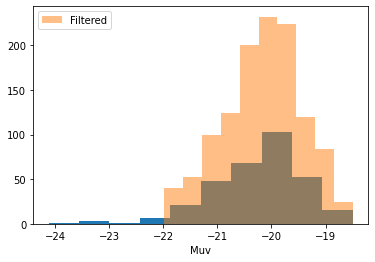

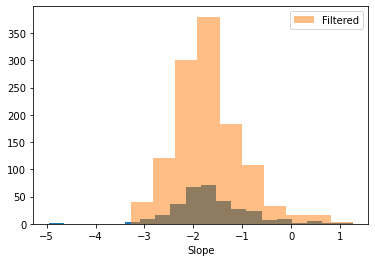

In [6]:
plt.hist(Muv)
plt.hist(BInf.Muv,alpha=0.5,label="Filtered")
plt.xlabel("Muv")
plt.legend()
plt.show()

plt.hist(slopes,bins=20)
plt.hist(BInf.UVslope,alpha=0.5,label="Filtered")
plt.xlabel("Slope")
plt.legend()
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.690236476403977
69.34909842693179


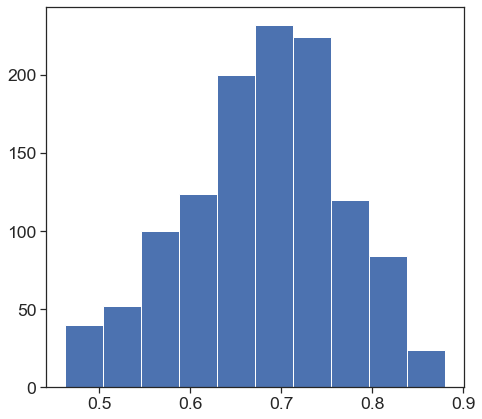

0
100
200
300
400
500
600
700
800
900
1000
1100
How well is A represented in mock data? (Atrue-Aobs):  0.022736476403977024


In [34]:
%load_ext autoreload
%autoreload

mockParamsA=[0.12,3.1]
mockParamsW=[8,230]
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])




x,probSets,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
print(np.median(As))
print(np.median(Ws))
plt.hist(As)
plt.show()
#Errors=np.array([p.getEWErrorMock()[0] for p in Photometry])
#UV=np.array([p.getEWErrorMock()[1:] for p in Photometry])
#BInf.UV=duplicate(UV[:,0])[mask]
#BInf.dUV=duplicate(UV[:,1])[mask]


#for prob,a,w in zip(probSets,As,Ws):
#
#    if a<0 or a>1 or w<0 or w>100:
#        continue
#    plt.plot(x[:],prob[:])
#    #print(a,w)
#    plt.xlabel("EW [A]")
#    plt.ylabel("p(EW)")
#    plt.ylim(-0.01,0.05)
#    plt.xlim(-100,300)
#plt.show()


mockEW=[]
i=0

mockA,mockW=[],[]
mockMuv,mockSlp=[],[]
#maskAW=[]
for prob,a,w,m,s in zip(probSets,As,Ws,BInf.Muv,BInf.UVslope):
    #if a<0 or a>1 or w<0 or w>100:
    #    print(i,a,w,m,s)
        #print(mockParamsA[0]*m+mockParamsA[1]*s+mockParamsA[2])
        #print(mockParamsW[0]*m + mockParamsW[1]*s +mockParamsW[2])
    #    maskAW.append(False)
    #    i=i+1
    #    continue

    #cases for when A  is too big or too small :
   # if a<0 or a>1 or w<0 or w>100:
   #     print(i,a,w,m,s)
   #     if a>1:
   #         a=1
   #     if a<0:
   #         a=0


    #maskAW.append(True)
    ew=RandomSampler(a,w)
    if a<0 or a>1:
        print(a,ew,m,s)
    mockEW.append(ew)
    mockA.append(a)
    mockW.append(w)
    mockMuv.append(m)
    mockSlp.append(s)

    if i%100==0:
        print(i)
    i=i+1


BInf.EW=np.array(mockEW)
BInf.RandomDrawEW(noise=3)
BInf.Classify(SNcut=3)
BInf.GenerateWtab()

#apply mask to MUV and slope so we have same number of elements
#BInf.Muv=BInf.Muv[maskAW]
#BInf.UVslope=BInf.UVslope[maskAW]
#BInf.dMuv=BInf.dMuv[maskAW]
#BInf.dSlp=BInf.dSlp[maskAW]
#BInf.zs=BInf.zs[maskAW]

print("How well is A represented in mock data? (Atrue-Aobs): ",np.median(mockA)-len(BInf.EW[BInf.EW!=0])/len(BInf.EW))




In [35]:
attributes = dir(BInf)
parameters = [attr for attr in attributes if not callable(getattr(BInf, attr)) and not attr.startswith("__")]
for i in parameters:
    try:
        print(i,len(getattr(BInf, i)))
    except:
        print(i,"couldnt")


EW 1200
EW_obs 1200
FWHM 1200
Lum 1200
Muv 1200
SNcut couldnt
Skew 1200
UV couldnt
UVslope 1200
dEW 1200
dMuv 1200
dSlp 1200
dUV couldnt
noise couldnt
orisize 1200
priorMuv 3
priorSlope 3
types 1200
wtab 1000
zs 1200


In [36]:

len(BInf.EW_obs)

1200

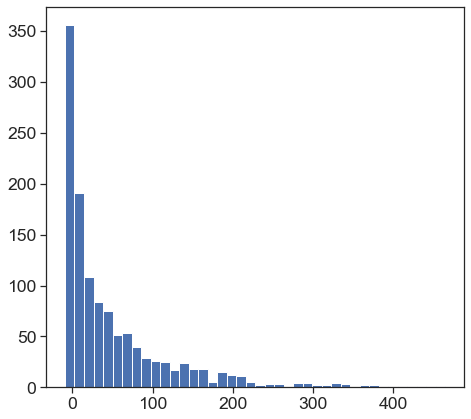

In [37]:
plt.hist(BInf.EW_obs,bins=40)
plt.show()

In [38]:
for ew,dew,t in zip(BInf.EW_obs,BInf.dEW,BInf.types):
    print(ew,dew,t,ew/dew)

1.6806341234218518 3 nonLAE 0.5602113744739506
3.4701831002109156 3 nonLAE 1.1567277000703051
137.168708803867 3 LAE 45.72290293462233
5.332922073448554 3 nonLAE 1.777640691149518
80.33700182717894 3 LAE 26.779000609059647
175.21824319722984 3 LAE 58.40608106574328
38.03454609550348 3 LAE 12.678182031834494
29.698406018733756 3 LAE 9.899468672911253
6.828986552562445 3 nonLAE 2.2763288508541484
56.42468158448437 3 LAE 18.808227194828124
43.095332223752536 3 LAE 14.365110741250845
241.03389170539816 3 LAE 80.34463056846606
22.405822161430567 3 LAE 7.468607387143522
12.946511037695375 3 LAE 4.315503679231791
379.67050825782496 3 LAE 126.55683608594165
-1.4859064695571134 3 nonLAE -0.4953021565190378
67.55912638286588 3 LAE 22.51970879428863
29.309497870489807 3 LAE 9.769832623496603
0.6707494403350931 3 nonLAE 0.22358314677836436
1.1092912073837864 3 nonLAE 0.3697637357945955
7.9277312647445415 3 nonLAE 2.6425770882481805
32.215954900089706 3 LAE 10.738651633363235
-1.6370048922953555 3 

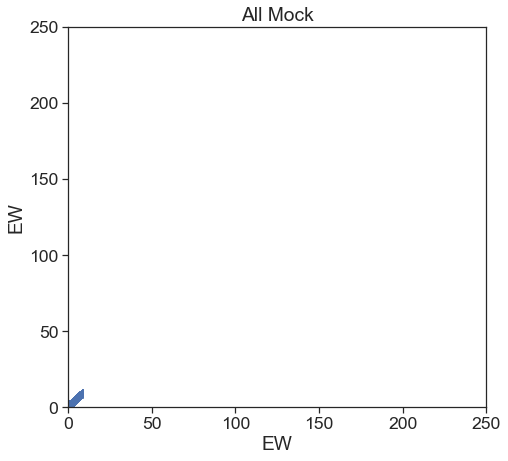

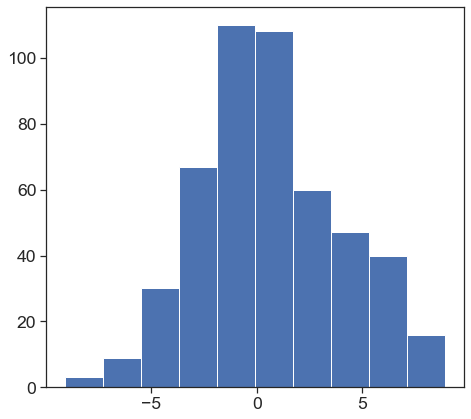

In [39]:
mask=np.array(BInf.types)=="nonLAE"

plt.errorbar(BInf.EW_obs[mask],BInf.EW_obs[mask],yerr=BInf.dEW[mask])
plt.xlim(0,250)
plt.ylim(0,250)
plt.xlabel("EW")
plt.ylabel("EW")
plt.title("All Mock")
plt.show()


plt.hist(BInf.EW_obs[mask],bins=10)
plt.show()

In [40]:
def modeloX(A,Wo,ew,dEW):
    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

In [42]:
for i in range(0,len(mockA)):
    print(mockA[i],mockW[i],mockMuv[i],mockSlp[i])

0.6891467682427219 69.27645121618144 -20.09044359797732 -1.122512921463695
0.7115006984689787 70.76671323126524 -19.904160846091845 -1.2144963276967338
0.673117803969526 68.20785359796838 -20.224018300253952 -1.486982619525139
0.5383150341598313 59.22100227732207 -21.34737471533474 -1.4991559907087004
0.5298814318520946 58.65876212347297 -21.41765473456588 -2.034600454172211
0.8588393205194871 80.58928803463246 -18.676338995670942 -1.6964200684325759
0.6780888757206558 68.53925838137704 -20.18259270232787 -1.6897456537170683
0.7381509136246569 72.5433942416438 -19.682075719794526 -2.18603226689946
0.7406723149464458 72.71148766309636 -19.661064042112955 -0.6791808092437448
0.7106198003972732 70.70798669315153 -19.91150166335606 -2.3280761470115476
0.6845224723061523 68.96816482041015 -20.12897939744873 -1.9169375170115734
0.6938472901514929 69.58981934343285 -20.051272582070894 1.2644111978441368
0.6100269327069401 64.001795513796 -20.7497755607755 -2.469508252212764
0.7149421428586149

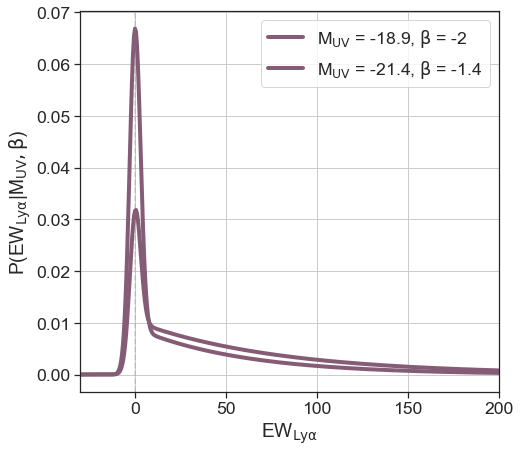

In [48]:
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap

cmap = ListedColormap(Antique_3.mpl_colors)
ew=np.linspace(-50.,500,1001)    
dew=np.full(len(ew),BInf.noise)

sns.set_theme(style="ticks",font_scale=1.6)
plt.rcParams["figure.figsize"] = (7.5,7.)
fig, axs = plt.subplots()


#case 1: 0.8223607581311265 78.15738387540841 -18.98032701557395 -2.011705594132862
#case 2: 0.5383150341598313 59.22100227732207 -21.34737471533474 -1.4991559907087004
#A=np.nanmedian(mockA)
#W=np.nanmedian(mockW)
y=modeloX(0.8,78,ew,dew)
axs.plot(ew,y,lw=4,color=cmap(0.1),label=r"M$_\mathrm{UV}$ = -18.9, $\mathrm{\beta}$ = -2")
y=modeloX(0.53,59,ew,dew)
axs.plot(ew,y,lw=4,color=cmap(0.1),label=r"M$_\mathrm{UV}$ = -21.4, $\mathrm{\beta}$ = -1.4")



axs.axvline(x=0,ls="--",color="gray",alpha=0.3)
#plt.ylim(0,0.5)
axs.set_xlim(-30,200)
axs.set_ylabel(r"P(EW$_\mathrm{Ly\alpha}$|M$_\mathrm{UV},\mathrm{\beta}$)")
axs.set_xlabel(r"EW$_\mathrm{Ly\alpha}$")
plt.grid()
plt.legend()
plt.show()


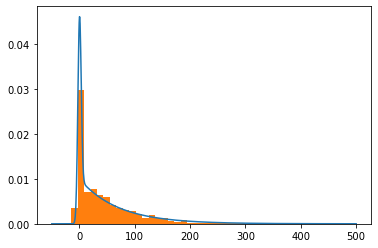

In [15]:
plt.plot(x,y)
plt.hist(BInf.EW_obs,bins=30,range=[-50,300],density=True)
plt.show()

## Test Mock Data

In [16]:
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
%load_ext autoreload
%autoreload


def log_prior(theta,BInf,physParams=BInf.Muv):
    # I can put priors here or in the equation in the BInf object 
    Auv,Ac,Wuv,Wc= theta
    A =   BInf.ParameterModel(physParams,[Auv,Ac])
    W =   BInf.ParameterModel(physParams,[Wuv,Wc])
    #print(A,W)
    if (A >= 0.).all() and (A <=1.0).all() and (W > 0.).all():# and (W < 500.).all():
        return 0.0 

    return -np.inf


def log_likelihood(theta,y,yerr,BInf,physParams=BInf.Muv):
    Auv,Ac,Wuv,Wc = theta
    model = BInf.Posterior(y,yerr,physParams,[Auv,Ac],[Wuv,Wc]) # Does thus have to be exp, so it gets outside the logaritm?

    return np.sum(np.log(model))

    

def log_probability(theta, y, yerr,BInf):
    #DrawnMuv=np.array([np.random.normal(loc=x,scale=dx) for x,dx in zip(BInf.Muv,BInf.dMuv)])
    #DrawnSlp=np.array([np.random.normal(loc=x,scale=dx) for x,dx in zip(BInf.UVslope,BInf.dSlp)])
    DrawnphysParams=BInf.Muv
    
    lp = log_prior(theta,BInf,physParams=DrawnphysParams)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,BInf,physParams=DrawnphysParams)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL


steps=12000
nwalkers=20
#mockParamsA=[0.02,-0.1,1.1]
#mockParamsW=[8,-5,235]

inValues=[0.005,1.,6,220]
pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
nwalkers, ndim = np.shape(pos)

mp_pool = multiproc.ProcessPool(nodes=8)
with mp_pool as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(BInf.EW_obs , BInf.dEW , BInf),pool=pool
    )
    sampler.run_mcmc(pos, steps, progress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/12000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/12000 [00:00<50:51,  3.93it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/12000 [00:00<48:17,  4.14it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encoun

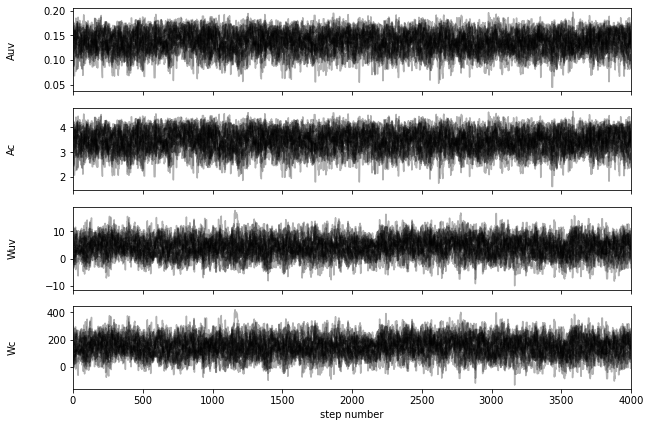

In [24]:


dis=8000
labels = ["Auv","Ac","Wuv","Wc"]
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=dis)
logProb=sampler.get_log_prob(discard=dis)
maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
samples=np.array([s[maskWalkers] for s in samples])
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()



(76000, 4)


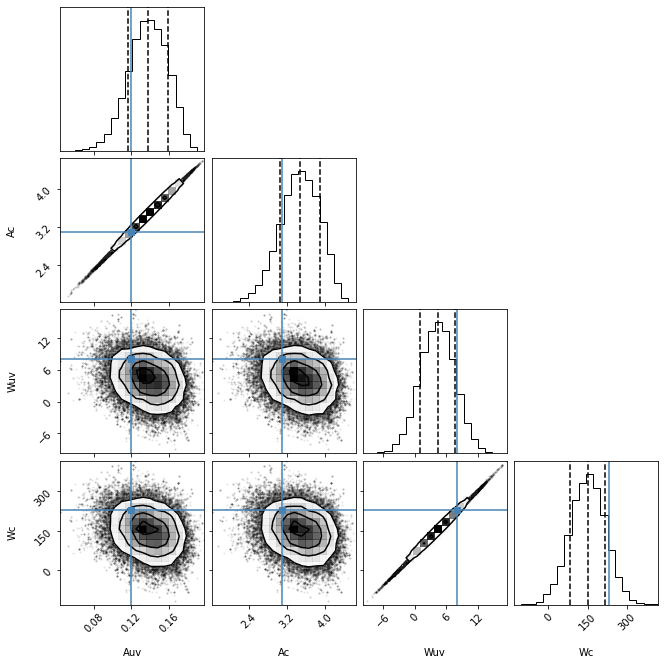

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
import corner
from IPython.display import display, Math


ndim=len(labels)
samples = sampler.get_chain(discard=dis)
samples=np.array([s[maskWalkers] for s in samples])
samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
print(np.shape(samples))


fig = corner.corner(
    samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
)
plt.show()

results=[]
r16,r84=[],[]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    results.append(mcmc[1])
    r16.append(mcmc[0])
    r84.append(mcmc[2])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


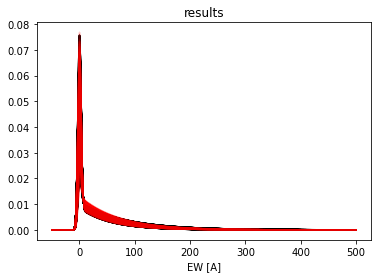

Median True values : 
A :  0.690236476403977
W0 :  69.34909842693179
Median Result values : 
A :  0.7142069065855505
W0 :  63.2573916485872


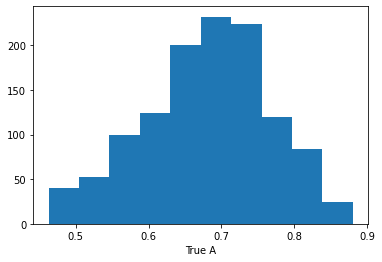

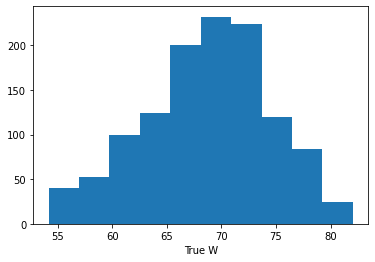

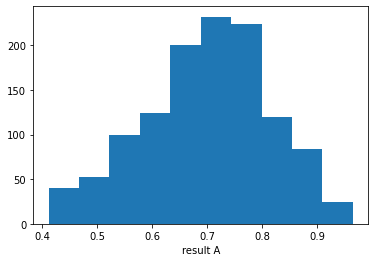

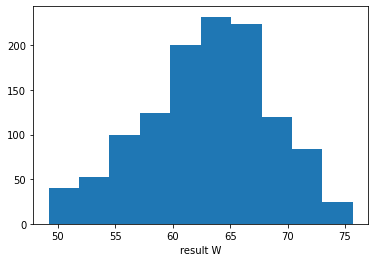

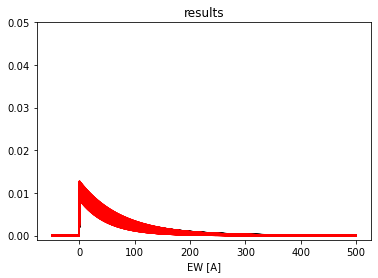

(array([534., 222., 156., 101.,  66.,  45.,  28.,  19.,   7.,   8.,   6.,
          3.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ -8.71861431,  17.14356405,  43.00574241,  68.86792078,
         94.73009914, 120.5922775 , 146.45445586, 172.31663423,
        198.17881259, 224.04099095, 249.90316932, 275.76534768,
        301.62752604, 327.4897044 , 353.35188277, 379.21406113,
        405.07623949, 430.93841786, 456.80059622, 482.66277458,
        508.52495294]),
 <BarContainer object of 20 artists>)

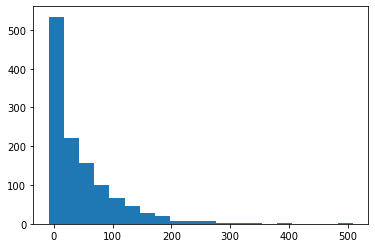

In [36]:
%load_ext autoreload
%autoreload


#print("RESULTS : ")
#print(results[0]*np.nanmedian(BInf.Muv)+results[1]*np.nanmedian(BInf.UVslope)+results[2])
#print(results[3]*np.nanmedian(BInf.Muv) + results[4]*np.nanmedian(BInf.UVslope) +results[5])


mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black")
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
#plt.show()
TrueAs=As
TrueWs=Ws




x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.show()
resultAs=As
resultWs=Ws
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r16As=As
r16Ws=Ws
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r84As=As
r84Ws=Ws

print("Median True values : ")
print("A : ",np.median(TrueAs))
print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))


plt.hist(TrueAs)
plt.xlabel("True A")
plt.show()

plt.hist(TrueWs)
plt.xlabel("True W")
plt.show()

plt.hist(As)
plt.xlabel("result A")
plt.show()

plt.hist(Ws)
plt.xlabel("result W")
plt.show()


#testA=[0.08,-0.6,1.1]
#testW=[11,-7.8,235]

#x,probSets,As,Ws=BInf.GenerateMockDataConvolved(testA,testW)
#for prob in probSets:
#    plt.plot(x,prob,color="green")
#    plt.ylim(-0.001,0.5)
#    plt.xlim(-0.001,20)
#    plt.xlabel("EW [A]")

plt.show()

x,probSets,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black")
    plt.ylim(-0.001,0.05)
    #plt.xlim(-0.001,20)
    plt.xlabel("EW [A]")


x,probSets,As,Ws=BInf.GenerateMockData(mParamsA,mParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="red")
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-0.001,20)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.show()

plt.hist(BInf.EW_obs,bins=20)

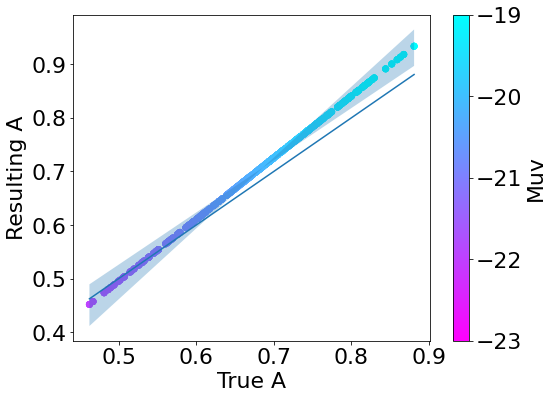

In [66]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 22})
cm = plt.cm.get_cmap('cool_r')


up,down=[],[]
for r,e in zip(r16As,r84As):
    if r>e:
        up.append(r)
        down.append(e)
    if e>r:
        up.append(e)
        down.append(r)

sc=plt.scatter(TrueAs,resultAs,c=BInf.Muv, vmin=-23, vmax=-19, cmap=cm)
plt.fill_between(np.sort(TrueAs),np.sort(up),np.sort(down),alpha=0.3)
#plt.fill_between(TrueAs,r16As,r84As)
#plt.scatter(TrueAs,r84As)
plt.colorbar(sc,label="Muv")
plt.plot([min(TrueAs),max(TrueAs)],[min(TrueAs),max(TrueAs)])
plt.xlabel("True A")
plt.ylabel("Resulting A")
plt.show()

#cm = plt.cm.get_cmap('cool')

#sc=plt.scatter(TrueAs,resultAs,c=BInf.UVslope, vmin=-3, vmax=0, cmap=cm)

#plt.colorbar(sc,label="Slope")
#plt.plot([0.4,0.9],[0.4,0.9])
#plt.xlabel("True A")
#plt.ylabel("Resulting A")
#plt.show()

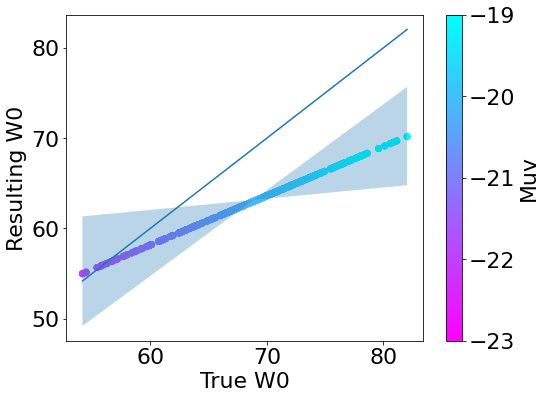

In [70]:
cm = plt.cm.get_cmap('cool_r')


up,down=[],[]
for r,e in zip(r16Ws,r84Ws):
    if r>e:
        up.append(r)
        down.append(e)
    if e>r:
        up.append(e)
        down.append(r)


sc=plt.scatter(TrueWs,resultWs,c=BInf.Muv, vmin=-23, vmax=-19, cmap=cm)
plt.fill_between(np.sort(TrueWs),np.sort(up),np.sort(down),alpha=0.3)
plt.colorbar(sc,label="Muv")
plt.plot([min(TrueWs),max(TrueWs)],[min(TrueWs),max(TrueWs)])
plt.xlabel("True W0")
plt.ylabel("Resulting W0")
plt.show()

#cm = plt.cm.get_cmap('cool')

#sc=plt.scatter(TrueWs,resultWs,c=BInf.UVslope, vmin=-3, vmax=0, cmap=cm)
#plt.colorbar(sc,label="Slope")
#plt.plot([20,60],[20,60])
#plt.xlabel("True W0")
#plt.ylabel("Resulting W0")
#plt.show()

In [69]:
down

[63.20131856176842,
 63.38640227893927,
 62.5313329660363,
 53.98798265198411,
 53.453489043090855,
 64.60632108408555,
 62.84638292729562,
 63.607057923583895,
 63.627934356693984,
 63.37910871186136,
 63.16303080330378,
 63.24023744800957,
 58.53284379867,
 63.41489638774357,
 60.45388500547236,
 62.3115588687258,
 64.30606135859787,
 62.949271970894586,
 63.20746240900349,
 63.86457224379076,
 53.65072896095748,
 54.78410039341895,
 63.5550696174096,
 63.99560263402981,
 64.12088960727576,
 63.75425709157586,
 63.32588810143098,
 56.57496073624799,
 51.528317791407744,
 58.99976085365944,
 62.82582927780203,
 60.020967893605274,
 60.41935458880013,
 51.20640506563356,
 61.30051815417201,
 54.80903167896227,
 58.89332468982926,
 62.87573469685455,
 63.44025322418295,
 63.74568329125117,
 49.181943165300765,
 54.65779547561871,
 57.568822949094255,
 60.96195434938559,
 57.30450638711736,
 63.130510320194816,
 63.519309707768215,
 63.649840969031985,
 55.86354162008243,
 63.29020693510

In [23]:
np.array(TrueWs)/np.array(resultWs)

array([1.09839974, 1.10766318, 1.09160806, ..., 1.08245336, 1.04137486,
       1.00572534])